<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/07-gan/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense, Dropout, Input,LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm_notebook
from tensorflow.keras.optimizers import Adam

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(60000, 784)
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)


In [3]:
def get_generator():
    model=Sequential()
    model.add(Dense(units=256,input_dim=100))
    model.add(LeakyReLU(0.2))
    
    model.add(Dense(units=512))
    model.add(LeakyReLU(0.2))
    
    model.add(Dense(units=1024))
    model.add(LeakyReLU(0.2))
    
    model.add(Dense(units=784, activation='tanh'))
    
#     model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))
    return model
g=get_generator()
g.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dens

In [4]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))
    return discriminator
d =create_discriminator()
d.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
___________________________

In [5]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential (Sequential)      (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()

In [7]:
batch_size=32
epochs=401
batch_count = X_train.shape[0] / batch_size

batch_count

1875.0

In [0]:
generator = get_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

In [0]:
for e in range(1, epochs+1):
    print("Epoch %d" %e)
#     for _ in tqdm_notebook(range(int(batch_count))):
    for _ in range(int(batch_count)):
        # generate  random noise as an input  to  initialize the  generator
        noise = np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
        generated_images = generator.predict(noise)
            
            # Get a random set of  real images
        image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            # Construct different batches of  real and fake data 
        X = np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
        y_dis=np.zeros(2*batch_size)
        y_dis[:batch_size]=0.9
            
            # Pre train discriminator on fake and real data before starting the gan. 
        discriminator.trainable=True
        discriminator.train_on_batch(X, y_dis)
            
            # Tricking the noised input of the Generator as real data
        noise= np.random.normal(0,1, [batch_size, 100])
        y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
        discriminator.trainable=False
            
            # training  the GAN by alternating the training of the Discriminator 
            # and training the chained GAN model with Discriminator’s weights freezed.
        gan.train_on_batch(noise, y_gen)
            
#         if e == 1 or e % 25 == 0:
#             plot_generated_images(e, generator)

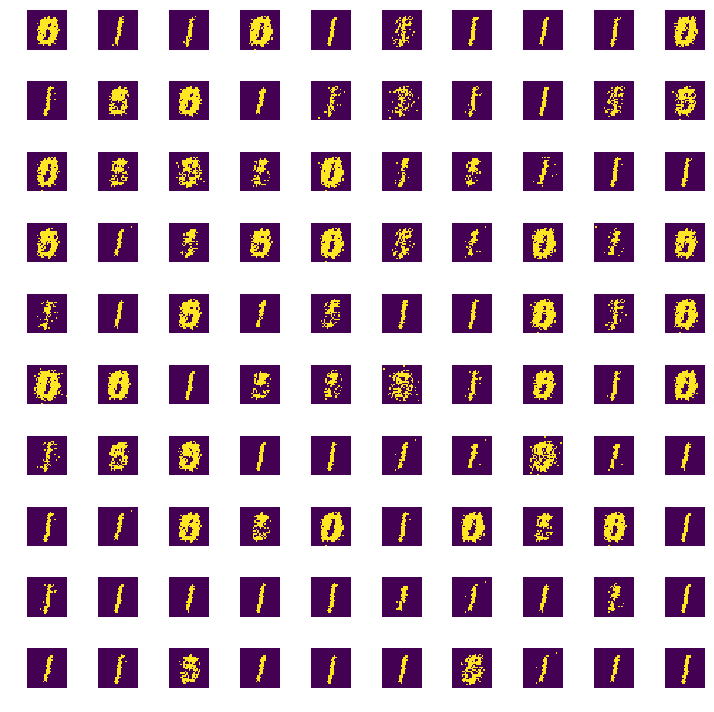

In [10]:
plot_generated_images(e, generator)

---

ДЗ - обучаем CGAN - на вход генератору подаём не только шум, но и лейбл, на выход получаем изображения указанного лейбла. Для реализации в дискриминаторе тоже нужен лейбл;)